In [2]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import os

metrics_dir = 'metrics/'
metrics_files = [f for f in os.listdir(metrics_dir) if f.endswith('.csv')]

# Dictionary to store all metrics
all_metrics = {}

# Read each metrics file
for file in metrics_files:
    file_path = os.path.join(metrics_dir, file)
    df = pd.read_csv(file_path)
    
    # Extract model name from filename or column name
    if len(df.columns) > 1:
        model_name = df.columns[1]  # Second column usually contains model name
    else:
        model_name = file.replace('metrics_', '').replace('.csv', '').upper()
    
    # Store metrics with model name as key
    all_metrics[model_name] = df.iloc[:, 1].values  # Second column contains the values

# Get metric names from the first file
metric_names = pd.read_csv(os.path.join(metrics_dir, metrics_files[0])).iloc[:, 0].values

# Create combined DataFrame
combined_df = pd.DataFrame(all_metrics, index=metric_names)


combined_df_display = combined_df.round(4)

print("="*80)
print("COMPREHENSIVE MODEL PERFORMANCE COMPARISON")
print("="*80)
print(tabulate(combined_df_display, headers='keys', tablefmt='pretty'))

# Find best performing models for each metric
print("\n" + "="*80)
print("BEST PERFORMING MODELS BY METRIC")
print("="*80)

best_models = {}
for metric in combined_df.index:
    if metric == 'Training time':
        # For training time, lower is better
        best_model = combined_df.loc[metric].idxmin()
        best_value = combined_df.loc[metric].min()
    elif metric in ['MSE', 'MAE', 'MSLE', 'MRSE']:
        # For error metrics, lower is better
        best_model = combined_df.loc[metric].idxmin()
        best_value = combined_df.loc[metric].min()
    else:
        # For R2 Score, higher is better
        best_model = combined_df.loc[metric].idxmax()
        best_value = combined_df.loc[metric].max()
    
    best_models[metric] = f"{best_model}: {best_value:.4f}"

for metric, best in best_models.items():
    print(f"{metric:15s}: {best}")

# Save combined metrics
combined_df.to_csv('metrics/combined_all_metrics.csv')
print(f"\nCombined metrics saved to 'metrics/combined_all_metrics.csv'")

# Create a summary table with top 3 models based on R2 Score
print("\n" + "="*60)
print("TOP 3 MODELS BY R2 SCORE")
print("="*60)

r2_scores = combined_df.loc['R2 Score'].sort_values(ascending=False)
top_3_models = r2_scores.head(3)

summary_data = []
for i, (model, r2) in enumerate(top_3_models.items(), 1):
    mse = combined_df.loc['MSE', model]
    mae = combined_df.loc['MAE', model]
    training_time = combined_df.loc['Training time', model]
    
    summary_data.append([
        f"#{i}",
        model,
        f"{r2:.4f}",
        f"{mse:.2f}",
        f"{mae:.4f}",
        f"{training_time:.2f}s"
    ])

summary_headers = ['Rank', 'Model', 'R2 Score', 'MSE', 'MAE', 'Training Time']
print(tabulate(summary_data, headers=summary_headers, tablefmt='pretty'))

COMPREHENSIVE MODEL PERFORMANCE COMPARISON
+---------------+------------------+------------------+------------------+---------------+------------+---------------+------------------+--------------+------------+------------------+
|               | Desicion_tree_GS | Decision_tree_RS | Random_forest_RS | NN TensorFlow | XGBoost_RS | MLP Regressor | Decision_tree_Op | TabPFN Model | XGBoost_Op | Random_forest_Op |
+---------------+------------------+------------------+------------------+---------------+------------+---------------+------------------+--------------+------------+------------------+
|   R2 Score    |      0.831       |      0.8195      |      0.7983      |    0.5827     |   0.9387   |    0.5649     |      0.7276      |    0.8231    |   0.7681   |      0.8107      |
|      MSE      |    1275.1436     |    1361.9817     |    1521.8001     |   2978.1181   |  443.9573  |   3282.9729   |    2055.0446     |  1334.5401   | 1749.2428  |    1428.4317     |
|      MAE      |     19.41

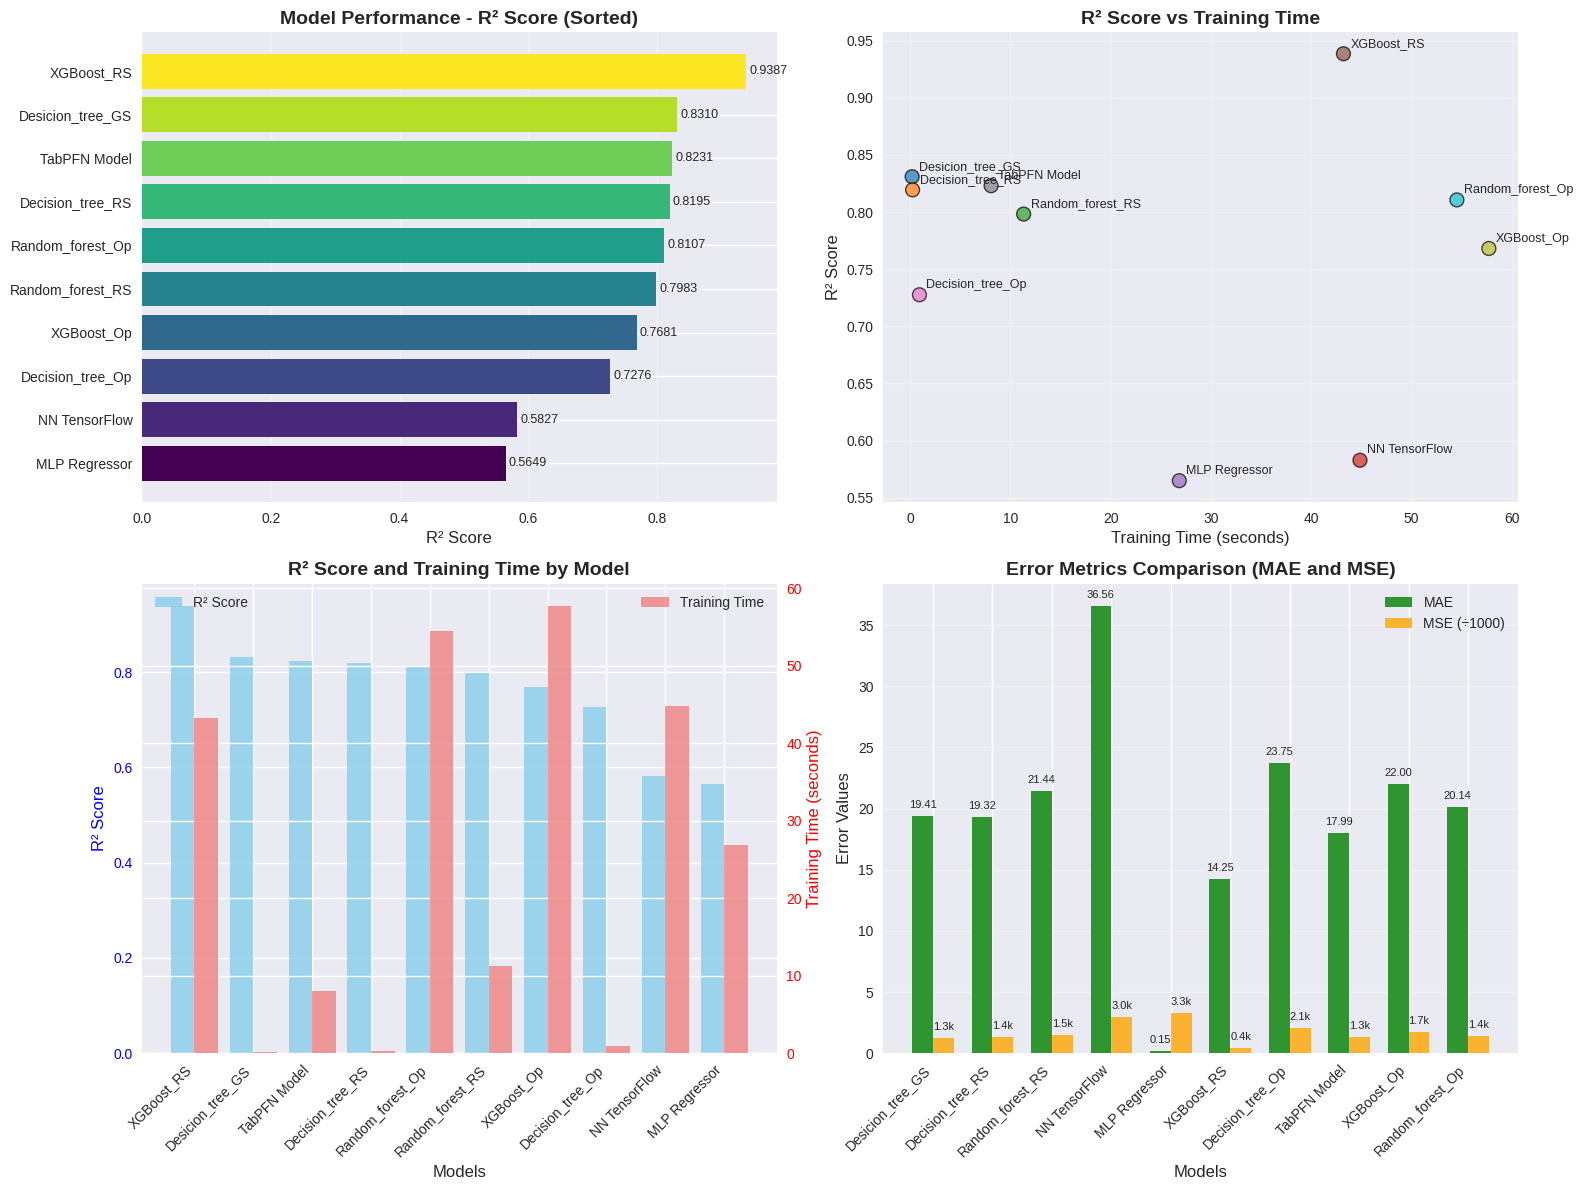


PERFORMANCE SUMMARY STATISTICS
+------------------+--------------------------+
|      Metric      |          Value           |
+------------------+--------------------------+
|  Best R² Score   |   0.9387 (XGBoost_RS)    |
|  Worst R² Score  |  0.5649 (MLP Regressor)  |
| Fastest Training | 0.21s (Desicion_tree_GS) |
| Slowest Training |   57.70s (XGBoost_Op)    |
+------------------+--------------------------+

MODEL EFFICIENCY ANALYSIS (R² Score per Second)
+------+------------------+-------------------+----------+---------------+
| Rank |      Model       | Efficiency (R²/s) | R² Score | Training Time |
+------+------------------+-------------------+----------+---------------+
|  #1  | Desicion_tree_GS |     3.983081      |  0.8310  |     0.21s     |
|  #2  | Decision_tree_RS |     3.250612      |  0.8195  |     0.25s     |
|  #3  | Decision_tree_Op |     0.776367      |  0.7276  |     0.94s     |
|  #4  |   TabPFN Model   |     0.101860      |  0.8231  |     8.08s     |
|  #5  | R

In [6]:
# Add visualization section
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Sorted R2 Score Bar Plot
r2_sorted = combined_df.loc['R2 Score'].sort_values(ascending=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(r2_sorted)))

bars1 = ax1.barh(range(len(r2_sorted)), r2_sorted.values, color=colors)
ax1.set_yticks(range(len(r2_sorted)))
ax1.set_yticklabels(r2_sorted.index, fontsize=10)
ax1.set_xlabel('R² Score', fontsize=12)
ax1.set_title('Model Performance - R² Score (Sorted)', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (idx, val) in enumerate(r2_sorted.items()):
    ax1.text(val + 0.005, i, f'{val:.4f}', va='center', ha='left', fontsize=9)

# 2. R2 Score vs Training Time Scatter Plot
training_times = combined_df.loc['Training time']
r2_scores_plot = combined_df.loc['R2 Score']

# Create scatter plot with different colors for each model
scatter = ax2.scatter(training_times, r2_scores_plot, 
                     s=100, alpha=0.7, c=range(len(training_times)), 
                     cmap='tab10', edgecolors='black', linewidth=1)

# Add model labels
for i, model in enumerate(training_times.index):
    ax2.annotate(model, 
                (training_times[model], r2_scores_plot[model]),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, ha='left')

ax2.set_xlabel('Training Time (seconds)', fontsize=12)
ax2.set_ylabel('R² Score', fontsize=12)
ax2.set_title('R² Score vs Training Time', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Dual-axis plot: R2 and Training Time
ax3_twin = ax3.twinx()

# Sort models by R2 score for consistent ordering
r2_sorted_models = combined_df.loc['R2 Score'].sort_values(ascending=False)
sorted_model_names = r2_sorted_models.index
x_pos = np.arange(len(sorted_model_names))

# Plot R2 scores as bars
bars_r2 = ax3.bar(x_pos - 0.2, [r2_sorted_models[model] for model in sorted_model_names], 
                  width=0.4, alpha=0.8, color='skyblue', label='R² Score')

# Plot training times as bars on secondary axis
training_times_sorted = [training_times[model] for model in sorted_model_names]
bars_time = ax3_twin.bar(x_pos + 0.2, training_times_sorted, 
                        width=0.4, alpha=0.8, color='lightcoral', label='Training Time')

# Customize axes
ax3.set_xlabel('Models', fontsize=12)
ax3.set_ylabel('R² Score', fontsize=12, color='blue')
ax3_twin.set_ylabel('Training Time (seconds)', fontsize=12, color='red')
ax3.set_title('R² Score and Training Time by Model', fontsize=14, fontweight='bold')

# Set x-axis labels
ax3.set_xticks(x_pos)
ax3.set_xticklabels(sorted_model_names, rotation=45, ha='right', fontsize=10)

# Add legends
ax3.legend(loc='upper left')
ax3_twin.legend(loc='upper right')

# Color the y-axis labels
ax3.tick_params(axis='y', labelcolor='blue')
ax3_twin.tick_params(axis='y', labelcolor='red')

# 4. Error Metrics Comparison (MAE and MSE)
mae_values = combined_df.loc['MAE']
mse_values = combined_df.loc['MSE']

# Normalize MSE for better comparison (divide by 1000)
mse_normalized = mse_values / 1000

x_pos_err = np.arange(len(mae_values))
width = 0.35

bars_mae = ax4.bar(x_pos_err - width/2, mae_values, width, 
                   alpha=0.8, color='green', label='MAE')
bars_mse = ax4.bar(x_pos_err + width/2, mse_normalized, width, 
                   alpha=0.8, color='orange', label='MSE (÷1000)')

ax4.set_xlabel('Models', fontsize=12)
ax4.set_ylabel('Error Values', fontsize=12)
ax4.set_title('Error Metrics Comparison (MAE and MSE)', fontsize=14, fontweight='bold')
ax4.set_xticks(x_pos_err)
ax4.set_xticklabels(mae_values.index, rotation=45, ha='right', fontsize=10)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Add value labels on error bars
for i, (mae, mse) in enumerate(zip(mae_values, mse_normalized)):
    ax4.text(i - width/2, mae + 0.5, f'{mae:.2f}', ha='center', va='bottom', fontsize=8)
    ax4.text(i + width/2, mse + 0.5, f'{mse:.1f}k', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('plots/comprehensive_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional summary statistics
print("\n" + "="*80)
print("PERFORMANCE SUMMARY STATISTICS")
print("="*80)

summary_stats = {
    'Metric': ['Best R² Score', 'Worst R² Score', 'Fastest Training', 'Slowest Training'],
    'Value': [
        f"{combined_df.loc['R2 Score'].max():.4f} ({combined_df.loc['R2 Score'].idxmax()})",
        f"{combined_df.loc['R2 Score'].min():.4f} ({combined_df.loc['R2 Score'].idxmin()})",
        f"{combined_df.loc['Training time'].min():.2f}s ({combined_df.loc['Training time'].idxmin()})",
        f"{combined_df.loc['Training time'].max():.2f}s ({combined_df.loc['Training time'].idxmax()})"
    ]
}

summary_stats_df = pd.DataFrame(summary_stats)
print(tabulate(summary_stats_df, headers='keys', tablefmt='pretty', showindex=False))

# Efficiency analysis (R2 per second)
print("\n" + "="*60)
print("MODEL EFFICIENCY ANALYSIS (R² Score per Second)")
print("="*60)

efficiency = combined_df.loc['R2 Score'] / combined_df.loc['Training time']
efficiency_sorted = efficiency.sort_values(ascending=False)

efficiency_data = []
for i, (model, eff) in enumerate(efficiency_sorted.items(), 1):
    r2 = combined_df.loc['R2 Score', model]
    time = combined_df.loc['Training time', model]
    efficiency_data.append([
        f"#{i}",
        model,
        f"{eff:.6f}",
        f"{r2:.4f}",
        f"{time:.2f}s"
    ])

efficiency_headers = ['Rank', 'Model', 'Efficiency (R²/s)', 'R² Score', 'Training Time']
print(tabulate(efficiency_data, headers=efficiency_headers, tablefmt='pretty'))